# Train on common 10000/28525, test on uncommon 2886

In [1]:
import pandas as pd
import time
import numpy as np
import pickle
from ClusteringPredictiveModel import ClusteringPredictiveModel
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from  matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from LastStateEncoder import LastStateEncoder
from datetime import datetime, timedelta

In [2]:
#data=pd.read_csv('BPIC 2017 just complete cases.csv',sep=';')

In [72]:
common=pd.read_csv('common cases.csv',sep=';')

In [73]:
uncommon=pd.read_csv('uncommon cases.csv',sep=';')

In [74]:
#x=data[0:20]

In [75]:
n_clusters = 6

In [76]:
#global case_id_col,event_col,timestamp_col,label_col,pos_label,numeric_cols,meta_event_data,other_col,variant_col

case_id_col = "Case ID"
event_col = "Activity"
timestamp_col = ["Complete Timestamp","Start Timestamp"]
label_col = 'lbl'
pos_label = 'A_Pending'
cat_cols = ['(case) LoanGoal','(case) ApplicationType'] 
numeric_cols = [ '(case) RequestedAmount',label_col]  
meta_event_data=['EventOrigin','OfferID','Unnamed: 0','Unnamed: 0.1','Transition','milli_seconds',
          'EventID','lifecycle:transition','days','D_seconds',
          'Accepted', 'Selected' ,
          'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms','outcome',
          'Resource','Variant', 'Action', 'CreditScore','OfferedAmount'
          ]
other_col= '(case) RequestedAmount'
variant_col='Variant index'

In [77]:
#data.drop(meta_event_data,axis=1,inplace=True)
#data.drop(variant_col,axis=1,inplace=True)
common.drop(meta_event_data,axis=1,inplace=True)
common.drop(variant_col,axis=1,inplace=True)
uncommon.drop(meta_event_data,axis=1,inplace=True)
uncommon.drop(variant_col,axis=1,inplace=True)

In [78]:
common.head()

,Case ID,Activity,Start Timestamp,Complete Timestamp,(case) ApplicationType,(case) LoanGoal,(case) RequestedAmount,lbl
0,Application_652823628,A_Create Application,2016/01/01 10:51:15.304,2016/01/01 10:51:15.304,New credit,Existing loan takeover,20000.0,A_Pending
1,Application_652823628,A_Submitted,2016/01/01 10:51:15.352,2016/01/01 10:51:15.352,New credit,Existing loan takeover,20000.0,A_Pending
2,Application_652823628,A_Concept,2016/01/01 10:52:36.413,2016/01/01 10:52:36.413,New credit,Existing loan takeover,20000.0,A_Pending
3,Application_652823628,W_Complete application,2016/01/02 11:45:22.429,2016/01/02 11:45:22.429,New credit,Existing loan takeover,20000.0,A_Pending
4,Application_652823628,A_Accepted,2016/01/02 12:23:04.299,2016/01/02 12:23:04.299,New credit,Existing loan takeover,20000.0,A_Pending


In [79]:
len(uncommon['Case ID'].unique())

2886

In [80]:
len(common['Case ID'].unique())

28525

In [81]:
# divide into train and test data
np.random.seed(22)
sample_cases_KMeans = np.random.choice(common[case_id_col].unique(), len(common[case_id_col].unique()))
train_cases_KMeans, test_cases_KMeans = train_test_split(sample_cases_KMeans , train_size = 4.0/5, random_state = 22 )
train_KMeans = common[common[case_id_col].isin(train_cases_KMeans)]
test_KMeans = common[common[case_id_col].isin(test_cases_KMeans)]

C:\Users\MSI\Miniconda3\envs\ch\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [82]:
# fit model (cluster traces and build classifier for each cluster)
model = ClusteringPredictiveModel(case_id_col, event_col, label_col, timestamp_col, cat_cols, numeric_cols, n_clusters=n_clusters, n_estimators=100, random_state=22, fillna=True)
model.fit(train_KMeans)

distribution clusters : 378    127    621    142    time:  33.0 day(s)
distribution clusters : 153    1615    147    2000    time:  15.0 day(s)
distribution clusters : 194    211    432    572    time:  23.0 day(s)
distribution clusters : 246    43    3196    612    time:  28.0 day(s)
distribution clusters : 87    595    145    795    time:  16.0 day(s)
distribution clusters : 275    798    448    1891    time:  18.0 day(s)


In [29]:
len(uncommon[uncommon['Case ID']==uncommon['Case ID'].unique()[60]])

24

In [59]:
req = uncommon[uncommon['Case ID']==uncommon['Case ID'].unique()[60]]
req=req[0:25]
len (req)

24

In [83]:
# predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
preds = model.predict_proba(uncommon )

distribution clusters :  163    284    103    103   time:  31.0 day(s)
distribution clusters :  14    55    3    52   time:  18.0 day(s)
distribution clusters :  332    346    246    284   time:  30.0 day(s)
distribution clusters :  0    16    18    37   time:  14.0 day(s)
distribution clusters :  24    129    21    100   time:  21.0 day(s)
distribution clusters :  64    246    50    196   time:  21.0 day(s)


In [84]:
preds

,Case ID,A_Pending,A_Denied,A_Cancelled
0,Application_1005568510,0.000000,0.000000,1.000000
1,Application_102424049,0.000000,0.000000,1.000000
2,Application_1041929908,0.000000,0.000000,1.000000
3,Application_1048806756,0.193367,0.000000,0.806633
4,Application_1049246293,0.000000,0.000000,1.000000
5,Application_1053321873,0.000000,0.000000,1.000000
6,Application_1084438713,0.000000,0.000000,1.000000
7,Application_1088749867,0.060807,0.000000,0.939193
8,Application_1089072317,0.000000,0.000000,1.000000
9,Application_111956933,0.000000,0.000000,1.000000


In [85]:
model.actual

,Case ID,A_Pending,A_Denied,A_Cancelled
0,Application_1005568510,0,0,1
1,Application_102424049,0,0,1
2,Application_1041929908,1,0,0
3,Application_1048806756,0,0,1
4,Application_1049246293,0,0,1
5,Application_1053321873,0,0,1
6,Application_1084438713,0,0,1
7,Application_1088749867,1,0,0
8,Application_1089072317,0,0,1
9,Application_111956933,0,0,1


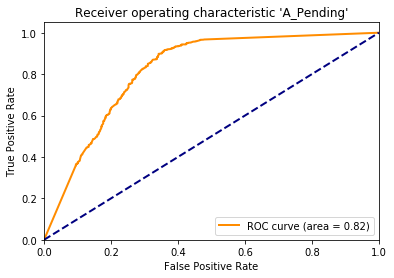

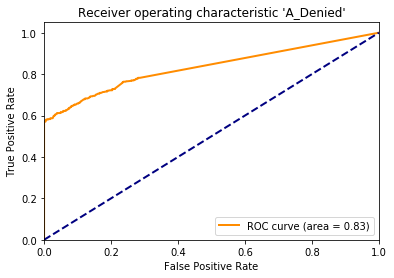

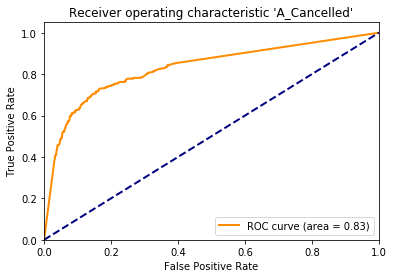

In [86]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(model.actual[model.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %model.actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

In [25]:
print(model.avg_sys)
print(model.avg_usr)

414165.36889
1429805.70069


# End,

In [52]:
ff=pd.get_dummies(f[label_col])

In [11]:
avg_grouping1=x.groupby(['Case ID'])
avg1=avg_grouping1.apply(lambda x: throughput(x))
avg_sys=np.mean([avg1[p][0] for p in range(len(avg1))])
avg_usr=np.mean([avg1[p][1] for p in range(len(avg1))])

In [12]:
print(avg_sys)
print(avg_usr)

50056.5
522281.5


In [27]:
def throughput(x):    
        i=x.index[0]
        t1=x['Start Timestamp'][i]
        t= time.strptime(t1, "%Y/%m/%d %H:%M:%S.%f")
        i+=1
        sys=0  # delay by system
        usr=0  # delay by user
        system=True
        while i < x.index.max():
            #print('before ', i)
            if x['Activity'][i]=='O_Sent (mail and online)' or x['Activity'][i]=='O_Sent (online only)':
                t2=x['Complete Timestamp'][i]
                t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                s=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                sys+=86400 * s.days + s.seconds
                system=False
                t=t2
                #print('send ',sys)

            if x['Activity'][i]=='A_Validating' :
                t2=x['Start Timestamp'][i]
                t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                u=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                usr+=86400 * u.days + u.seconds
                system=True
                t=t2
                #print('val :',usr)

            i+=1
            #print(i)
            if i==x.index.max():
                if system:
                    t2=x['Complete Timestamp'][i]
                    t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                    s=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                    sys+=86400 * s.days + s.seconds
                    #print('final sys  ',sys)
                else:
                    t2=x['Complete Timestamp'][i]
                    t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                    u=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                    usr+=86400 * u.days + u.seconds
                    #print('fainal usr ',usr)
        #return np.array([sys,usr])
        return sys,usr

In [23]:
def execution_time(x):
        t=x['Start Timestamp'][x.index.min()]
        t = time.strptime(t, "%Y/%m/%d %H:%M:%S.%f")
        t2=x['Complete Timestamp'][x.index.max()]
        t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
        #print(t)
        #print(t2)
        exe=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
        return (86400 * exe.days + exe.seconds)

#execution_time(x)
# encode events as frequencies
#data_freqs = self.freq_encoder.fit_transform(X)

# cluster traces according to event frequencies 
#cluster_assignments = self.clustering.fit_predict(data_freqs)

avg_grouping=x.groupby(['Case ID'])
avg=avg_grouping.apply(lambda x: execution_time(x))


In [23]:
avg_sys=50056.5
avg_usr=522281.5

In [25]:
def sort_and_calculate(x):
        sys,usr=throughput(x)
        th_col=['sys','usr']
        x=x.tail(1).drop(timestamp_col, axis=1)
        #x=pd.concat([x,th_col],axis=1)
        x['sys']=sys
        x['usr']=usr
        return x

In [30]:
sort_and_calculate(x)

,Case ID,Activity,(case) ApplicationType,(case) LoanGoal,(case) RequestedAmount,lbl,sys,usr
99,Application_1085880569,W_Complete application,New credit,Existing loan takeover,13000.0,A_Cancelled,-3994588,4087824


In [31]:
x=data[0:100]

In [32]:
grouped = x.groupby(case_id_col)

# extract values from last event
#data = grouped.apply(lambda x: x.sort_values(by=self.timestamp_col, ascending=True).tail(1)).drop(self.timestamp_col, axis=1)
x = grouped.apply(lambda x: sort_and_calculate(x).drop(['Activity'],axis=1))


In [67]:
def sub_family(x):# for one case
        if x['sys'][0]>avg_sys and x['usr'][0]>avg_usr:   #ss
            return 0
        elif x['sys'][0]>avg_sys and x['usr'][0]<avg_usr: #sf
            return 1
        elif x['sys'][0]<avg_sys and x['usr'][0]>avg_usr: #fs
            return 2
        elif x['sys'][0]<avg_sys and x['usr'][0]<avg_usr: #ff
            return 3 

In [76]:
for i in range(1,len(x)+1):
    print(i, '   ' ,x.head(i).tail(1))

1                                               Case ID (case) ApplicationType  \
Case ID                                                                    
Application_1085880569 99  Application_1085880569             New credit   

                                  (case) LoanGoal  (case) RequestedAmount  \
Case ID                                                                     
Application_1085880569 99  Existing loan takeover                 13000.0   

                                   lbl    sys  usr  
Case ID                                             
Application_1085880569 99  A_Cancelled  81592    0  
2                                               Case ID (case) ApplicationType  \
Case ID                                                                    
Application_1691306052 32  Application_1691306052             New credit   

                            (case) LoanGoal  (case) RequestedAmount       lbl  \
Case ID                                                   

In [70]:
sub_family(x)

1

In [66]:
m['sys'][0]

81592

In [71]:
x

,,Case ID,(case) ApplicationType,(case) LoanGoal,(case) RequestedAmount,lbl,sys,usr
Case ID,,,,,,,,
Application_1085880569,99,Application_1085880569,New credit,Existing loan takeover,13000.0,A_Cancelled,81592,0
Application_1691306052,32,Application_1691306052,New credit,Home improvement,10000.0,A_Denied,102994,427024
Application_1746793196,83,Application_1746793196,New credit,Car,5000.0,A_Pending,682578,1649260
Application_428409768,55,Application_428409768,New credit,Home improvement,15000.0,A_Pending,140734,966902
Application_652823628,18,Application_652823628,New credit,Existing loan takeover,20000.0,A_Pending,100113,1044563
Application_828200680,95,Application_828200680,New credit,Home improvement,35000.0,A_Cancelled,81832,2661384


In [8]:
# trim first n activity
#######################

n=15


n_events=pd.DataFrame(columns=test_KMeans.columns)
for i in test_cases_KMeans[0:10]:
    #cc=test_KMeans[test_KMeans['Case ID']==i]
    n_events=n_events.append(test_KMeans[test_KMeans['Case ID']==i][0:n])
n_events=test_KMeans[test_KMeans.index.isin(n_events.index) ]

In [10]:
# events from '''''''  to '''''''
#if not: from_event=A_Create Application

from_event= 'A_Submitted'

to_event  = 'A_Accepted'

from_to=pd.DataFrame(columns=test_KMeans.columns)
#idx=dd[dd['Activity'].values==from_event].index
#idx2=dd[dd['Activity'].values==to_event].index  
#cd=test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))]

for i in test_cases_KMeans[0:100]:
    dd=test_KMeans[test_KMeans['Case ID']==i]
    idx=dd[dd['Activity'].values==from_event].index
    if not idx.any():
        idx=dd[dd['Activity'].values=='A_Create Application'].index
    idx2=dd[dd['Activity'].values==to_event].index 
    from_to=from_to.append(test_KMeans[test_KMeans.index.isin (range(idx[0],idx2[0]+1))])

In [12]:
# predict for test set (assign each trace to the closest cluster and predict outcome using the corresponding classifier)
preds = model.predict_proba(test_KMeans )

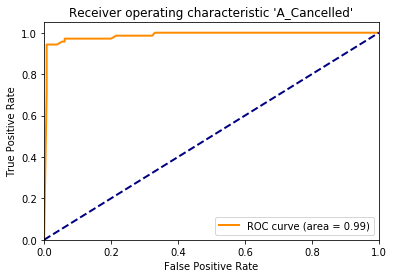

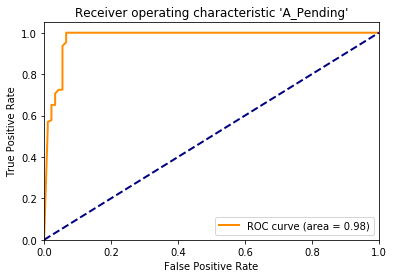

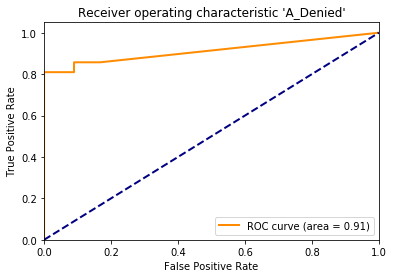

In [9]:
import sklearn.metrics as met
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
th=dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i],th[i] = met.roc_curve(model.actual[model.actual.columns.values[i+1]],preds[preds.columns.values[i+1]])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(3):
    plt.figure()
    lw = i
    plt.plot(fpr[i], tpr[i], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic %r' %model.actual.columns.values[i+1])
    plt.legend(loc="lower right")
    plt.show()

In [231]:
def throughput(x):    
    first=True
    i=x.index[0]
    t1=x['Start Timestamp'][0]
    t= time.strptime(t1, "%Y/%m/%d %H:%M:%S.%f")
    i+=1
    sys=0  # delay by system
    usr=0  # delay by user
    system=True
    while i < x.index.max():
        #print('before ', i)
        if x['Activity'][i]=='O_Sent (mail and online)' or x['Activity'][i]=='O_Sent (online only)':
            t2=x['Complete Timestamp'][i]
            t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
            s=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
            sys+=86400 * s.days + s.seconds
            system=False
            t=t2
            #print('send ',sys)

        if x['Activity'][i]=='A_Validating' :
            t2=x['Start Timestamp'][i]
            t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
            u=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
            usr+=86400 * u.days + u.seconds
            system=True
            t=t2
            #print('val :',usr)

        i+=1
        #print(i)
        if i==x.index.max():
            if system:
                t2=x['Complete Timestamp'][i]
                t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                s=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                sys+=86400 * s.days + s.seconds
                #print('final sys  ',sys)
            else:
                t2=x['Complete Timestamp'][i]
                t2 = time.strptime(t2, "%Y/%m/%d %H:%M:%S.%f")
                u=datetime.fromtimestamp(time.mktime(t2))-datetime.fromtimestamp(time.mktime(t))
                usr+=86400 * u.days + u.seconds
                #print('fainal usr ',usr)
    return sys,usr
